# 2. Exploratory Data Analysis & Pre-Processing



In determining how to configure our predictive model, we will explore the target variable, Sale Price, and look through
key predictor variables that may impact our target.

In [96]:
#the usual imports for EDA and Visualization

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [97]:
#reading csv

train = pd.read_csv('./datasets/train_clean.csv')
test = pd.read_csv('./datasets/test_clean.csv')

In [98]:
#let's check out the target's summary statistics  we're trying to predict

train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [2]:
#InterQuartile Range Calculation:

IQR = 214000 - 129825
IQR

#Most price values tend to fall within a range of $84,175.

84175

In [99]:
#the mean price is $181,469.7, and we have a mean that's larger than the median of $162,500
# which means it is positively skewed

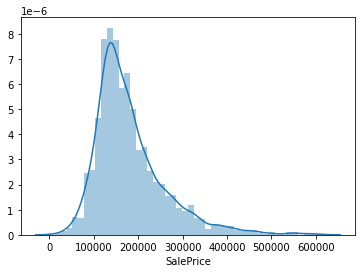

In [100]:
sns.distplot(train['SalePrice']);

#the distplots shows some houses fair exceed the 75th percentile of 214000, we know the max was above 600,000.
#much later when we regularize we will address outliers using ridge, lasso and elastic net

## Correlations between Continuous Predictors and Price

In [101]:
#function modified to find continuous predictors like LotArea etc

In [102]:
#after pouring through Data Dictionary,
#any time there's a continuous variable other than SalePrice, only keywords like Frontage, SF, Area and Porch are used
#so I made a for loop to catch them all in one continuous predictor list

continuous=[]

continuous = [col for col in train.columns if 'Frontage' in col or 'SF' in col or 'Area' in col or 'Porch' in col]

print(continuous)

['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area']


In [103]:
len(continuous)

18

In [104]:
df_corr = train[continuous]

In [105]:
#add sale price into our continuous variable list for heatmapping

df_corr['SalePrice']=train['SalePrice']

/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


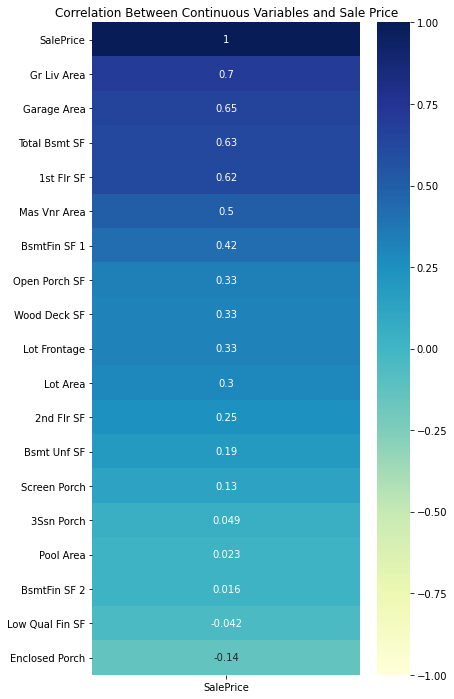

In [106]:
#created a 19 x 1 heatmap to illustrate the correlation of our continuous variables with the price

price_heatmap = df_corr.corr()[['SalePrice']].sort_values(['SalePrice'],ascending = False)

plt.figure(figsize = (6,12))
sns.heatmap(price_heatmap, vmin = -1, vmax = 1, cmap = "YlGnBu", annot = True)
plt.title('Correlation Between Continuous Variables and Sale Price');

#### The strongest correlations (0.5 and above) are, in descending order:
* Above Ground Living Areas (0.7)
* Garage Areas (0.65), 
* Total Basement Square Footage (0.63), 
* 1st Floor Square Footage (0.62),
* and Masonry Veneer Area (0.5).


Explanation: this makes sense because Above Ground Living indicates houses with more than one storey, meaning it has at least more than 1 floor; a basement increases the real estate space with a sublevel, and a garage also impacts value with private car parking. 

Naturally, it also makes sense that how large the 1st Floor is has an impact on price - the built-up space where people spend most of their time in on a property seems to matter more than Pool Areas or Porches, for example (both less than 0.2 correlation). 

People also place a premium on the appearance of spending on brickwork - even masonry veneer is only a facade and the interior is something cheaper like wood or metal:https://en.wikipedia.org/wiki/Masonry_veneer 

### How Spread Out or Linear are the correlations between all continuous predictors vs price?

In [107]:
#plotting the best and worst variables against price by first assigning the groups accordingly:

best_continuous = ['Mas Vnr Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Area', 'Gr Liv Area']

worst_continuous= [column for column in continuous if column not in best_continuous]

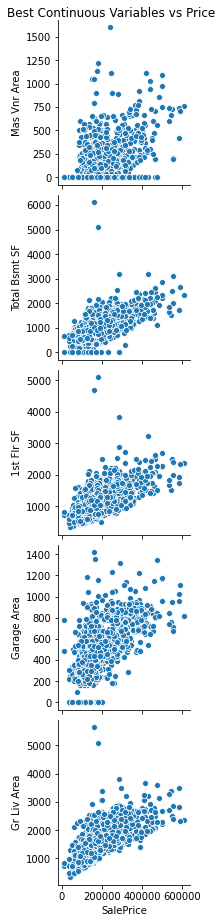

In [108]:
#we can use a pairplot to check out the best predictors out:
good_scatter = sns.pairplot(train, y_vars=best_continuous, x_vars=['SalePrice'], aspect = 1)

good_scatter.fig.suptitle("Best Continuous Variables vs Price", y=1.01);

We see from the scatterplots that there is significant linear correlation between our 5 best predictors, but there are outliers at the top of each scatterplot that roughly correspond to the same area; indicating how for some houses, even a large square footage/area will not proportionately pay out more.

At the same time, there is skew in most of our top correlated predictors thanks to the outliers.

In [109]:
#let's see the summary stats for the best continuous predictors:

test[best_continuous].describe().T

count         mean         std    min     25%     50%     75%  \
Mas Vnr Area   879.0   106.861206  188.284115    0.0     0.0     0.0   173.0   
Total Bsmt SF  879.0  1036.750853  419.258428    0.0   790.0   975.0  1248.0   
1st Flr SF     879.0  1148.053470  381.022337  407.0   864.0  1064.0  1358.0   
Garage Area    879.0   470.832765  213.070155    0.0   323.0   473.0   576.0   
Gr Liv Area    879.0  1500.531286  517.413260  407.0  1114.0  1436.0  1781.0   

                  max  
Mas Vnr Area   1378.0  
Total Bsmt SF  3138.0  
1st Flr SF     3138.0  
Garage Area    1488.0  
Gr Liv Area    4676.0

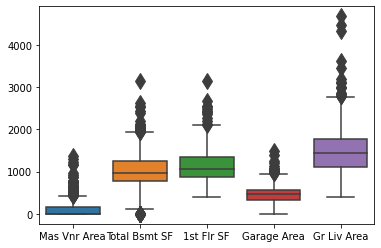

In [110]:
#best to plot these 5 on a boxplot and see how bad the outliers are
#magnified the outliers in the big black diamonds.

sns.boxplot(data=test[best_continuous], width=0.8, fliersize= 12, orient='v').set_title;

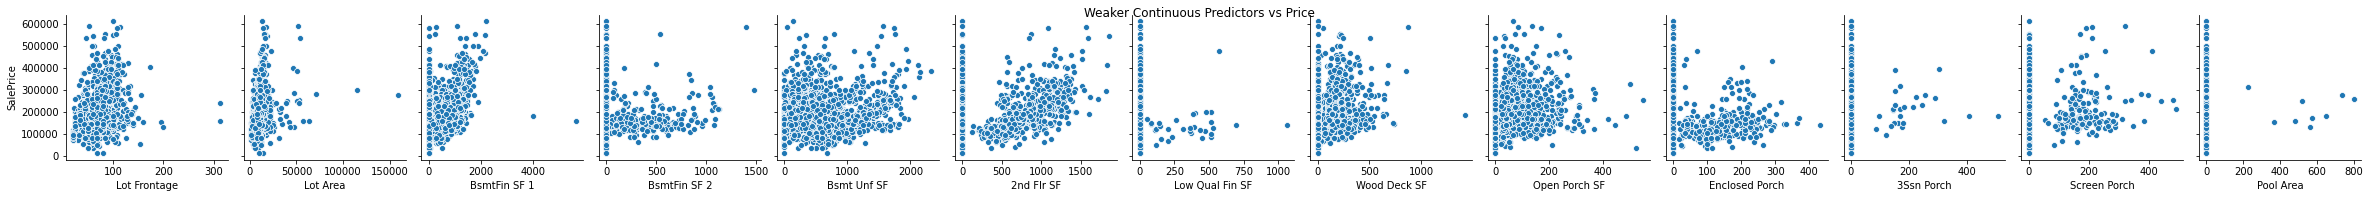

In [111]:
#we can use a pairplot to check the distribution of the worst predictors out:

poor_scatter = sns.pairplot(train, x_vars=worst_continuous, y_vars=['SalePrice'], aspect = 1)

poor_scatter.fig.suptitle("Weaker Continuous Predictors vs Price", y=1.02);

the skew is pretty bad for these predictors, especially the poor predictors.
note that there are some inferable correlations between 2nd Floor Square Footage in our poor predictors,
and our highly-price-correlated Above Grade (Ground) Living Area predictor. 

Later I can apply a regularization technique to smoothen their distributions to account for collinear variables and outliers.

## Correlation of Discrete Variables and Price

In [112]:
#we need a way to figure out what's discrete and what's continuous variables

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     2051 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

In [113]:
#a 'for' loop can help us filter for discretes with ordinal numerical rankings. 
#we see from the Data Dictionary that discrete ordinal variables have no more than 10 unique values.
discr_feat=[]

for column in train.columns:
    if train[column].dtype=='int64' and len(train[column].unique()) <=10:
        discr_feat.append(column)

In [114]:
#lets see what discr_feat contains:
discr_feat

['Overall Qual',
 'Overall Cond',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'Fireplaces',
 'Pool Area',
 'Yr Sold']

In [115]:
#pool area doesn't sound like it should be discrete. Indeed, the Data Dictionary confirms it as continuous. 
# Let's remove from our discrete variables columns using .pop

train['Pool Area'].sort_values(ascending=False)

761     800
1249    738
1130    648
657     576
1875    561
       ... 
1371      0
1372      0
1373      0
1374      0
0         0
Name: Pool Area, Length: 2051, dtype: int64

In [116]:
discr_feat.pop(7)

print(discr_feat)

['Overall Qual', 'Overall Cond', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Fireplaces', 'Yr Sold']


The last variable in our discrete features based is "year sold". We will not plot this as a ranked discrete numerical variable since it's merely a measurement of time. Other time-related features are discussed later.

In [117]:
#lets plot the discrete numerical variables against price. because its qualitative vs quantitative variables, 
#we will use histograms

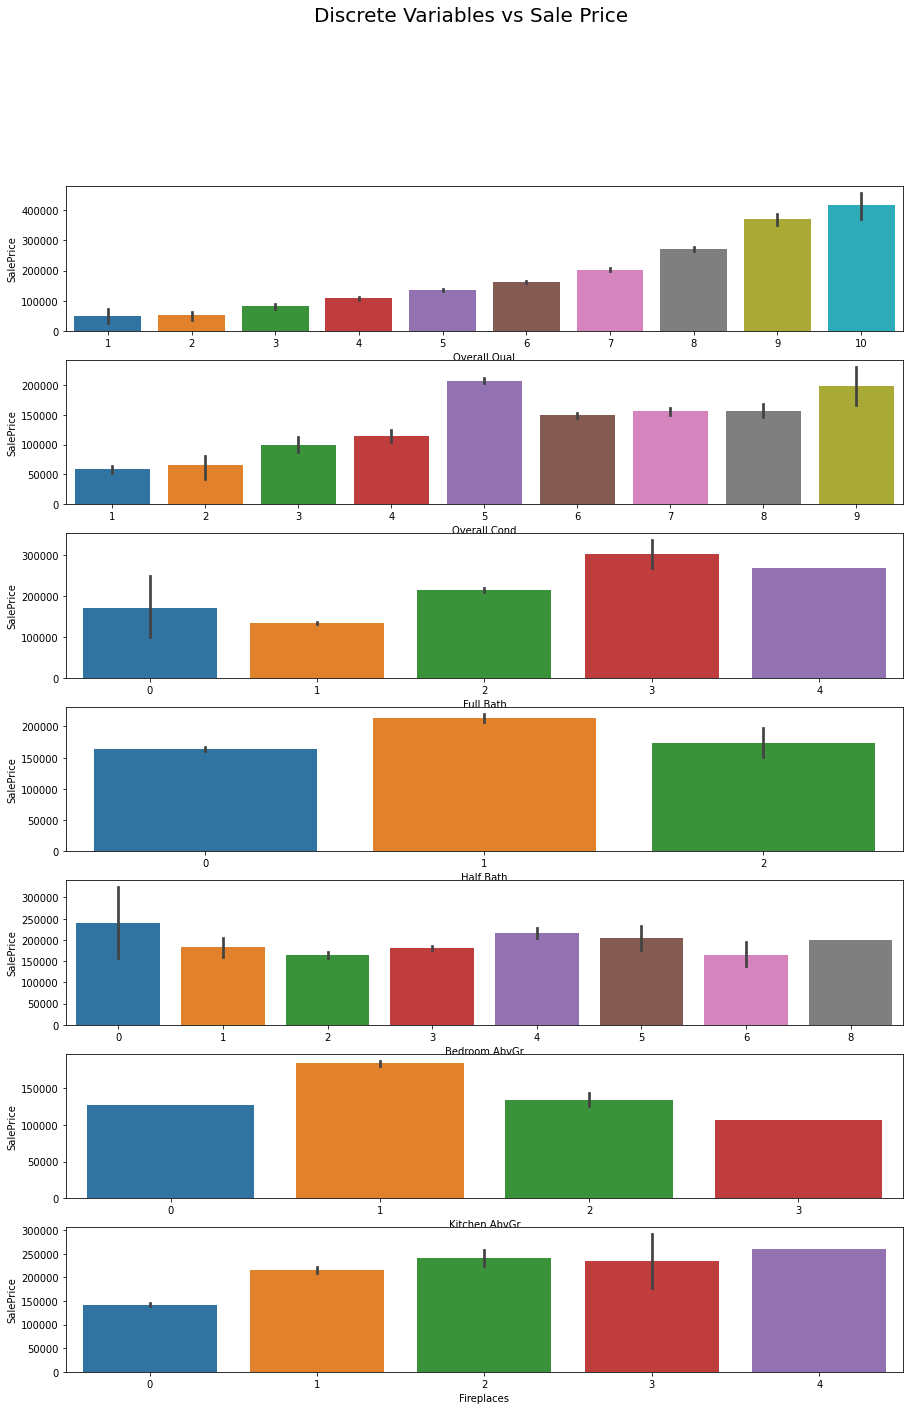

In [119]:
fig = plt.figure(figsize=(15,25))

ax1 = plt.subplot(811)
ax1 = sns.barplot(data=train,x="Overall Qual",y="SalePrice")

ax2 = plt.subplot(812)
ax2 = sns.barplot(data=train,x="Overall Cond",y="SalePrice")

ax3 = plt.subplot(813)
ax3 = sns.barplot(data=train,x="Full Bath",y="SalePrice")

ax4 = plt.subplot(814)
ax4 = sns.barplot(data=train,x="Half Bath",y="SalePrice")

ax5 = plt.subplot(815)
ax5 = sns.barplot(data=train,x="Bedroom AbvGr",y="SalePrice")

ax6 = plt.subplot(816)
ax6 = sns.barplot(data=train,x="Kitchen AbvGr",y="SalePrice")

ax7 = plt.subplot(817)
ax7 = sns.barplot(data=train,x="Fireplaces",y="SalePrice")

plt.suptitle("Discrete Variables vs Sale Price",fontsize=20);

#### * Fireplaces, Overall Quality & Condition: As materials and conditions are ranked higher, sale price rises, and that correlation is most obvious here for discrete variables.

* For Full or Half Bathrooms: 3 Bathrooms commands the highest price, but people won't pay more for more than 1 half-bath

* For Bedrooms and Kitchens above 'Grade': the Data Dictionary defines Grade as Ground. More elevated bedrooms command higher prices, but prices level off and decline with more than 4 increased elevated kitchens.

## Categorical Variables and Price

In [24]:
#function to call category variables:

categoricals=[column for column in train if train[column].dtype=='object']

In [25]:
len(categoricals)

#we have a whopping 38 categorical variables to contend with. 

38

In [26]:
categoricals

['MS Zoning',
 'Street',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Sale Type']

In [27]:
#some categoricals that are labeled as strings need to have type changed and appended to our categoricals

train['MS SubClass'] = train['MS SubClass'].apply(str)

In [28]:
#we do the same for the test set and append to our list

test['MS SubClass'] = test['MS SubClass'].apply(str)

In [29]:
categoricals=[column for column in train if train[column].dtype=='object']

In [30]:
#re ran our column adder for loop to include MS SubClass

In [31]:
#assigning columns of categoricals into cat_columns
categoricals_df=train[categoricals]

cat_columns = categoricals_df.columns

In [32]:
#crafted a function to create one large group of bar chart subplots for the categoricals 
#hspace parameter in subplots_adjust will space out the graphs so that axes titles don't overlap

def bar_charter(*args):
    import math
    
    chart_groups = []
    for column in args:
        chart_groups.append(train.groupby(column).size())
        
    no_of_rows = math.ceil(len(chart_groups)/4)
    
    fig, ax = plt.subplots(no_of_rows,4,figsize = (16,4*no_of_rows))
    
    fig.subplots_adjust(hspace=0.5)
    
    for ind, grp in enumerate(chart_groups):   
        grp.plot(kind = 'bar', ax = ax[ind//4][ind%4])

    plt.show()

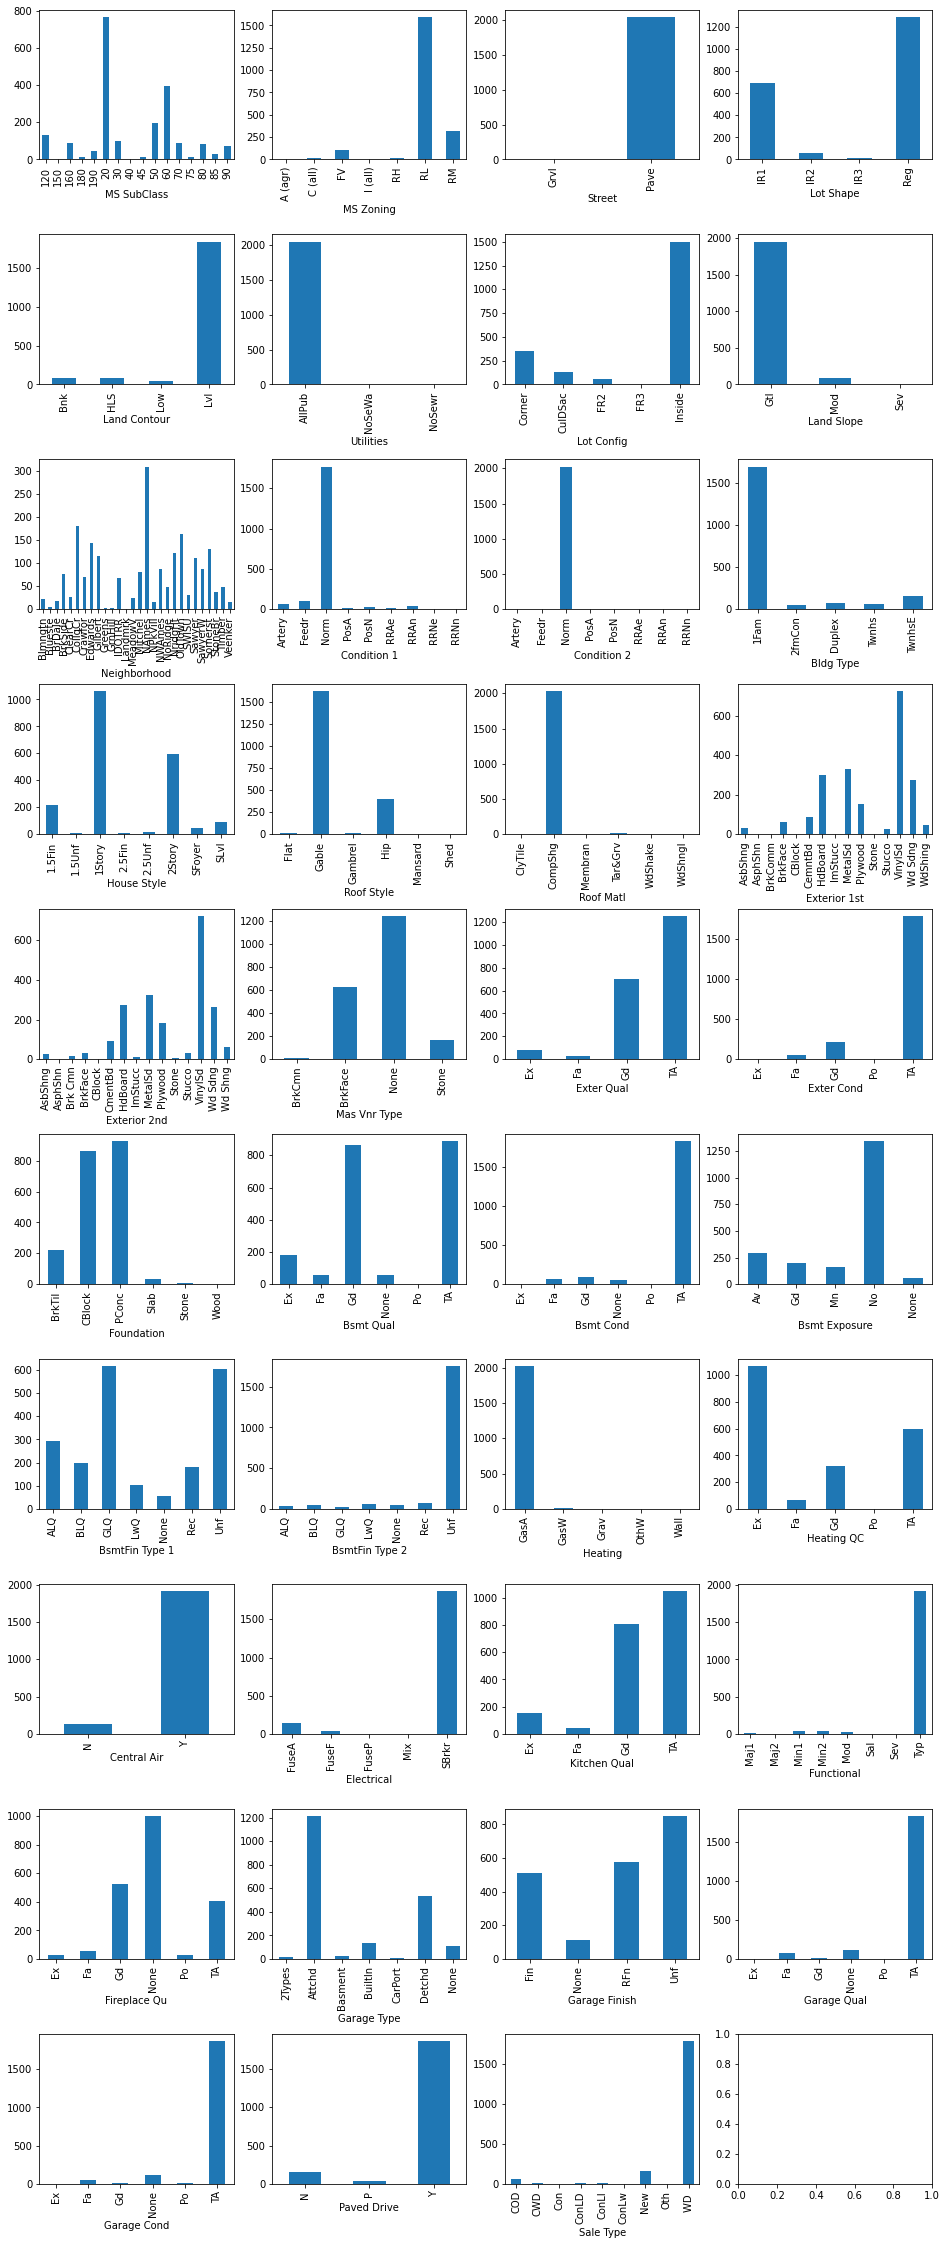

In [33]:
bar_charter(*cat_columns)

In [34]:
len(categoricals)

39

In [35]:
#Visually it seems a lot of categoricals are dominated by a single category like Street, 
#Utilities, Condition 2, Roof Material, and Heating.
#let's see what what the size of the values are per column

train.groupby('Street').size()


Street
Grvl       7
Pave    2044
dtype: int64

In [36]:
train.groupby('Utilities').size()


Utilities
AllPub    2049
NoSeWa       1
NoSewr       1
dtype: int64

In [37]:
train.groupby('Condition 2').size()


Condition 2
Artery       5
Feedr       11
Norm      2025
PosA         3
PosN         3
RRAe         1
RRAn         1
RRNn         2
dtype: int64

In [38]:
train.groupby('Roof Matl').size()


Roof Matl
ClyTile       1
CompShg    2025
Membran       1
Tar&Grv      15
WdShake       4
WdShngl       5
dtype: int64

In [39]:
train.groupby('Heating').size()


Heating
GasA    2018
GasW      20
Grav       5
OthW       2
Wall       6
dtype: int64

### Late Stage Cleaning

What this tells us is that for each of those columns, 98%-99.7% of the column data is dominated by one value. We already have more than 30 Category Predictors.
We can afford to dropped unhelpfully single-value dominated Categories, so will drop that now:

In [40]:
test.drop(['Street', 'Utilities', 'Condition 2', 'Roof Matl', 'Heating'], axis=1, inplace = True)

In [41]:
#repeating over both datasets

train.drop(['Street', 'Utilities', 'Condition 2', 'Roof Matl', 'Heating'], axis=1, inplace = True)

In [42]:
categoricals=[column for column in train if train[column].dtype=='object']

In [43]:
len(categoricals)

34

In [44]:
train.shape

(2051, 72)

In [45]:
test.shape

(879, 71)

### The Judgement Call on Many, Many Categorical Variables & Solving our Problem Statement

Recalling our Problem Statement:

"Can we help real estate agents in the city of Ames, Iowa predict the sale price of a house based on housing and real estate data using an **accessible Linear Regression model**?"

We know there are 39 categorical variables. Are we likely to succeed in our project's purpose by literally incorporating every single column (before encoding) into our model? 

On the one hand, doing so would mean that every possible factor has been accounted for - right down to whether the driveway was paved with Dirt or Gravel ("Paved Drive"). 

However, two issues arise:

* **Overfitting Risk**: For us to achieve success on Linear Regression, we take into account the risk of over-fitting. If we include literally every single column for the sake of being a completionist, that would mean we would need to one-hot encode each type of ordinal column, or create more and more dummy variables in order to engineer our features sufficiently. This runs the risk of our model over-fitting. 

    This means that even if we were to train our model exceptionally well on the train set with the lowest bias possible, having 38 variables (before even adding on the discrete and continuous numerical predictors) would unduly overburden our model. This would likely result in our test set suffering from high variance on unseen data.

* **Accessibility**: given that real estate agents are our target users, they need to strike a balance between the information they can obtain in a commercially feasible way, without jeopardizing client timelines. Real estate agents typically treat time as of the essence in their work. 

    To expect them to model estimates about home prices based on the neighbourhood location in is one thing. To ask them to assess any marginal difference in home value based on whether dirt or gravel is used in the driveway is quite another. The information must be reasonably accurate, but still swiftly accessible to a real estate agent working on the clock.

### EDA: The Broad Categories that Matter

With those issues in mind we will focus on analyzing some key categories that may impact Sale Price.

According to RedBrick and PropertyGuru, research indicates that the top 5 factors impacting price are: 

1. Suburb/Neighbourhood

2. Additions and Upgrades: e.g. Fireplaces and Basement Categories

3. Time - Age of House

4. Quality and Condition: External Materials Quality 

5. Size of House: we already have covered continuous square footage earlier, but there's also MS SubClass

Sources: 
https://www.propertyguru.com.my/property-guides/10-factors-impact-property-value-malaysia-13228
https://www.redbrick.sg/blog/what-affects-real-estate-prices/

We will conduct EDA on at least 1 key Category each per factor.

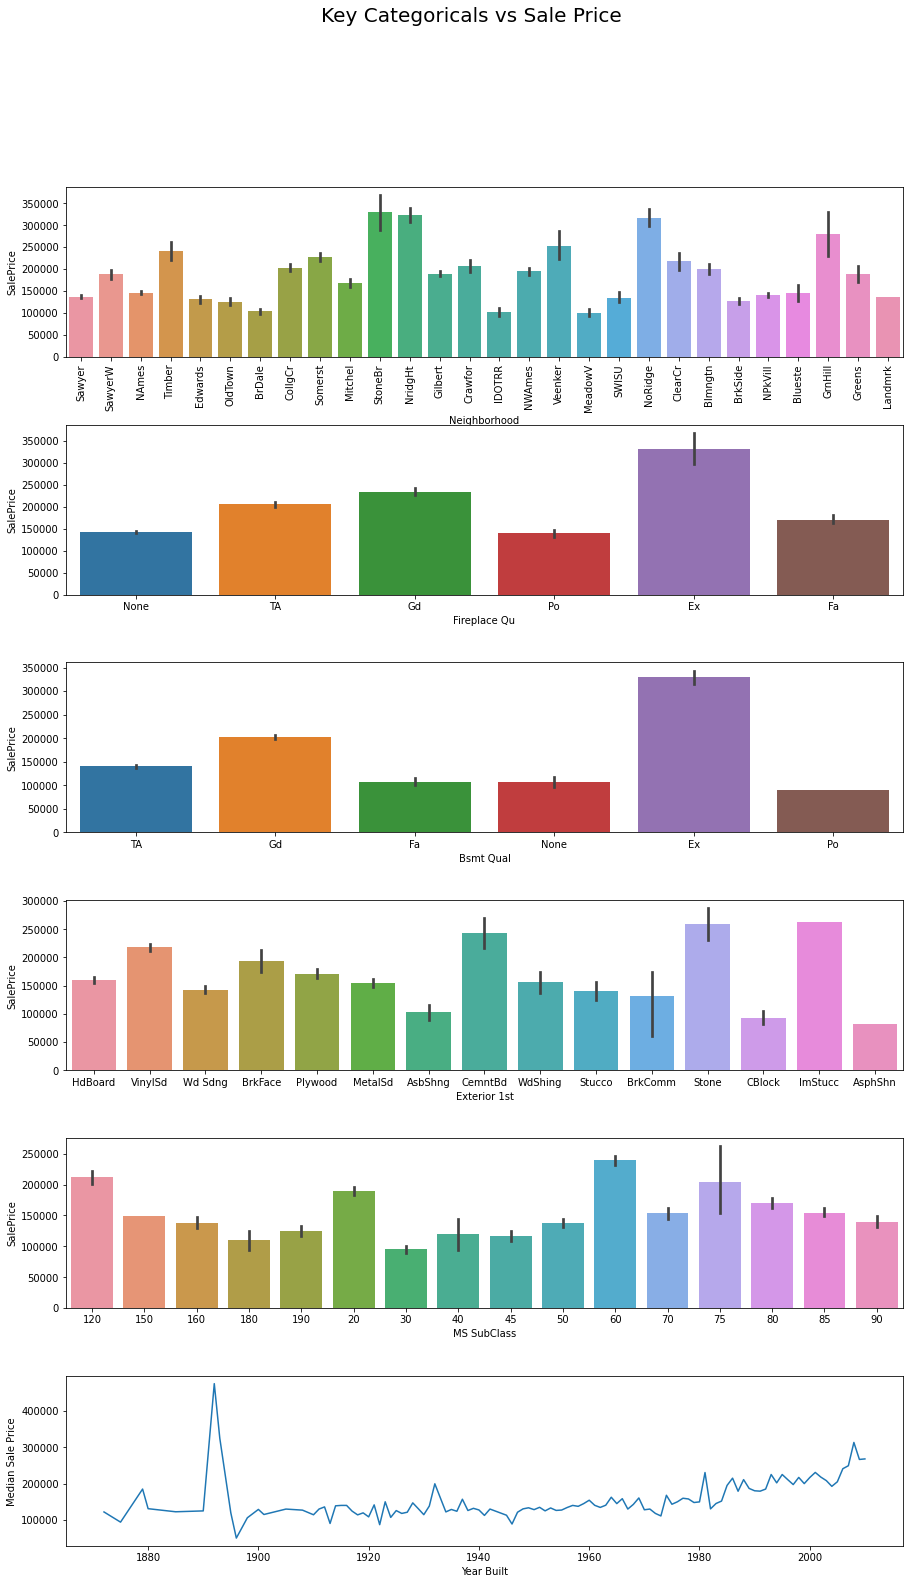

In [46]:
fig = plt.figure(figsize=(15,25))

#found a way to space out subplots 
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
plt.subplots_adjust(hspace=0.4)

ax1 = plt.subplot(611)
ax1 = sns.barplot(data=train,x="Neighborhood",y="SalePrice")
ax1 = plt.xticks(rotation=90)
#figured out axis rotation online also: 
# https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib

ax2 = plt.subplot(612)
ax2 = sns.barplot(data=train,x="Fireplace Qu",y="SalePrice")

ax3 = plt.subplot(613)
ax3 = sns.barplot(data=train,x="Bsmt Qual",y="SalePrice")

ax4 = plt.subplot(614)
ax4 = sns.barplot(data=train,x="Exterior 1st",y="SalePrice")

ax5 = plt.subplot(615)
ax5 = sns.barplot(data=train,x="MS SubClass",y="SalePrice")

ax6 = plt.subplot(616)
ax6 = train.groupby(['Year Built'])['SalePrice'].median().plot()
ax6 = plt.ylabel("Median Sale Price")

plt.suptitle("Key Categoricals vs Sale Price",fontsize=20);

**Categorical Interpretation - preferred predictors**

1. Suburb/Neighbourhood: where you live impacts your property value. Suburbs like Stone Brook, Northridge, Northridge Heights, Greenhills and Veenker command far higher property values than elsewhere.

2. Additions and Upgrades: e.g. Fireplaces and Basement Categories: The quality of specific additional fixtures in the house like fireplaces and basement impact sale price also - Good and Excellent ranked fireplaces and basements draw far higher prices.

3. Age of House: older homes tend to sell for less than newer homes, most likely due to maintenance issues. Having said that, there was a massive exception to an older pre-1900 house which sold for the largest amount ever, skewing our data.

4. Quality and Condition: The Exterior Materials of a house also correlate with price- stronger materials like Cement and Stone command higher prices, whilst sub-standard toxic asbestos causes the value to plummet.  

5. Size of House: we already have covered continuous square footage earlier, but there's also MS SubClass - which basically indicates what home type the house is. The most expensive houses are typically class 60 aka 2-Story houses that are built after 1946 - again driving home our point about older houses selling lower.

## Addressing Skew and Pre-Processing

### Logarithmic Scaling

In [47]:
#We saw a lot of skewed items in our top predictors. We can apply a logarithmic transformation 
#this will help us get a more normalized set which helps regression:

train['log_Total Bsmt SF']=np.log(train['Total Bsmt SF']) - returns infinite value in column 
train['log_1st Flr SF']=np.log(train['1st Flr SF'])
train['log_Year Built']=np.log(train['Year Built'])

/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


The error message only shows how problematic it becomes later in modelling, where it is fixed

In [48]:
#and we do the same for our test set

test['log_1st Flr SF']=np.log(test['1st Flr SF'])
test['log_Year Built']=np.log(test['Year Built'])
test['log_Total Bsmt SF']=np.log(test['Total Bsmt SF']) - train error with same value


In [51]:
#for consistency and simplicity, Year Remod/Add and Year sold 
#will be logarithmically transformed also and appended
#and month sold will be removed so that we don't have double timeframes to worry about

In [52]:
train['log_Year Remod_Add']=np.log(train['Year Remod/Add'])
test['log_Yr Sold']=np.log(test['Yr Sold'])

In [53]:
test['log_Year Remod_Add']=np.log(test['Year Remod/Add'])
train['log_Yr Sold']=np.log(train['Yr Sold'])

In [57]:
train.drop(['Year Built', 'Year Remod/Add', 'Mo Sold', 'Yr Sold'], axis = 1, inplace = True)

In [59]:
test.drop(['Year Built', 'Year Remod/Add', 'Mo Sold', 'Yr Sold'], axis = 1, inplace = True)

### Dummies

In [61]:
# exporting a new csv in case rollback needed
# will create dummie columns for categoricals and create new variables to store them
train.to_csv('./datasets/train_clean_log.csv')

In [62]:
test.to_csv('./datasets/test_clean_log.csv')

In [63]:
dummy_train = pd.read_csv('./datasets/train_clean_log.csv')

In [64]:
dummy_test = pd.read_csv('./datasets/test_clean_log.csv')

In [66]:
dummies_in_train = pd.get_dummies(dummy_train, drop_first=True)

In [67]:
dummies_in_test = pd.get_dummies(dummy_test, drop_first=True)

In [69]:
dummies_in_train.shape

(2051, 232)

In [70]:
dummies_in_test.shape

(879, 223)

In [71]:
#number of columns are different across the dataframes. we will reconcile both with a function 
#that deletes whats missing

In [76]:
train_columns = dummies_in_train.columns
test_columns = dummies_in_test.columns

train_cols_not_in_test = [n for n in train_columns if n not in test_columns]

train_cols_not_in_test.remove("SalePrice")

In [77]:
train_cols_not_in_test

['MS Zoning_C (all)',
 'Neighborhood_GrnHill',
 'Neighborhood_Landmrk',
 'Exterior 1st_CBlock',
 'Exterior 1st_ImStucc',
 'Exterior 1st_Stone',
 'Exterior 2nd_Stone',
 'Bsmt Cond_Fa',
 'Bsmt Cond_Po',
 'Heating QC_Po',
 'Electrical_Mix',
 'Functional_Sal',
 'Functional_Sev',
 'Garage Qual_Fa']

In [78]:
dummies_in_train.drop(train_cols_not_in_test, axis = 1, inplace = True)

In [79]:
dummies_in_train.shape

(2051, 218)

In [80]:
#now there are more entries in test that have to be reconciled. 
#So we do the converse with the same function

test_cols_not_in_train = [n for n in test_columns if n not in train_columns]
test_cols_not_in_train

['Exterior 1st_PreCast',
 'Exterior 2nd_Other',
 'Exterior 2nd_PreCast',
 'Mas Vnr Type_CBlock',
 'Kitchen Qual_Po',
 'Sale Type_VWD']

In [81]:
dummies_in_test.drop(test_cols_not_in_train, axis = 1, inplace = True)

In [88]:
dummies_in_test.head()

Unnamed: 0  Unnamed: 0.1        PID  MS SubClass  Lot Frontage  Lot Area  \
0           0             0  902301120          190          69.0      9142   
1           1             1  905108090           90          68.0      9662   
2           2             2  528218130           60          58.0     17104   
3           3             3  902207150           30          60.0      8520   
4           4             4  535105100           20          68.0      9500   

   Overall Qual  Overall Cond  Mas Vnr Area  BsmtFin SF 1  ...  Paved Drive_P  \
0             6             8           0.0           0.0  ...              0   
1             5             4           0.0           0.0  ...              0   
2             7             5           0.0         554.0  ...              0   
3             5             6           0.0           0.0  ...              0   
4             6             5         247.0         609.0  ...              0   

   Paved Drive_Y  Sale Type_CWD  Sale Type_Con  Sale Type_ConLD  \
0              1              0              0                0   
1              1              0              0                0   
2              1              0              0                0   
3              0              0              0                0   
4              1              0              0                0   

   Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  Sale Type_Oth  \
0                0                0              0              0   
1                0                0              0              0   
2                0                0              1              0   
3                0                0              0              0   
4                0                0              0              0   

   Sale Type_WD   
0              1  
1              1  
2              0  
3              1  
4              1  

[5 rows x 217 columns]

In [92]:
#apart from the indexing column errors, PID is an irrelevant metric according to the Data Dictionary 

dummies_in_test.drop(['Unnamed: 0', 'Unnamed: 0.1', 'PID'], axis=1, inplace = True)

In [90]:

dummies_in_train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'PID'], axis=1, inplace = True)

In [91]:
dummies_in_train.head()

MS SubClass  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0           60          68.0     13517             6             8   
1           60          43.0     11492             7             5   
2           20          68.0      7922             5             7   
3           60          73.0      9802             5             5   
4           50          82.0     14235             6             8   

   Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  ...  \
0         289.0         533.0           0.0        192.0          725.0  ...   
1         132.0         637.0           0.0        276.0          913.0  ...   
2           0.0         731.0           0.0        326.0         1057.0  ...   
3           0.0           0.0           0.0        384.0          384.0  ...   
4           0.0           0.0           0.0        676.0          676.0  ...   

   Paved Drive_P  Paved Drive_Y  Sale Type_CWD  Sale Type_Con  \
0              0              1              0              0   
1              0              1              0              0   
2              0              1              0              0   
3              0              1              0              0   
4              0              0              0              0   

   Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  \
0                0                0                0              0   
1                0                0                0              0   
2                0                0                0              0   
3                0                0                0              0   
4                0                0                0              0   

   Sale Type_Oth  Sale Type_WD   
0              0              1  
1              0              1  
2              0              1  
3              0              1  
4              0              1  

[5 rows x 215 columns]

In [93]:
#finally reconciled at last.
dummies_in_test.head()

MS SubClass  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0          190          69.0      9142             6             8   
1           90          68.0      9662             5             4   
2           60          58.0     17104             7             5   
3           30          60.0      8520             5             6   
4           20          68.0      9500             6             5   

   Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  ...  \
0           0.0           0.0           0.0       1020.0         1020.0  ...   
1           0.0           0.0           0.0       1967.0         1967.0  ...   
2           0.0         554.0           0.0        100.0          654.0  ...   
3           0.0           0.0           0.0        968.0          968.0  ...   
4         247.0         609.0           0.0        785.0         1394.0  ...   

   Paved Drive_P  Paved Drive_Y  Sale Type_CWD  Sale Type_Con  \
0              0              1              0              0   
1              0              1              0              0   
2              0              1              0              0   
3              0              0              0              0   
4              0              1              0              0   

   Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  \
0                0                0                0              0   
1                0                0                0              0   
2                0                0                0              1   
3                0                0                0              0   
4                0                0                0              0   

   Sale Type_Oth  Sale Type_WD   
0              0              1  
1              0              1  
2              0              0  
3              0              1  
4              0              1  

[5 rows x 214 columns]

In [94]:
dummies_in_train.to_csv('./datasets/train_clean_log.csv')

In [95]:
dummies_in_test.to_csv('./datasets/test_clean_log.csv')

### Now Moving Onto:
## 3. Modelling and Conclusion